# Setup

In [2]:
%%capture
import scanpy as sc
import scvi
import os
import seaborn as sns
from numpy import var, mean, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.lines as mlines
import numpy as np
import warnings
from scipy.stats import spearmanr
import scipy
from scipy.stats import ttest_ind

In [3]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

# Set up file paths

## demeter

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

## gardner-lab-computer

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Methods

### effect size

In [7]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

### num genes expressed

In [8]:
def plot_total_genes_normalized_expression(
    adata, genotype_list, threshold=0.02, save_path=None, layer="scVI_normalized", cell_type_key="cell_type",
    genotype_key="genotype", vlim = None, cell_type_list=None, *args, **kwargs,
):
    adata_copy = adata[adata.obs[genotype_key].isin(genotype_list)]
    normalized_expression = pd.DataFrame(
        adata_copy.layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy.var_names
    )
    normalized_expression = np.log1p(normalized_expression)
    adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)

    df = sc.get.obs_df(adata_copy, [f"nGenes_normalized_{threshold}", cell_type_key, genotype_key])
    if cell_type_list is not None:
        df = df[df[cell_type_key].isin(cell_type_list)]
        df[cell_type_key].cat.remove_unused_categories(inplace=True)
        df[cell_type_key].cat.reorder_categories(cell_type_list, inplace=True)
    df[genotype_key].cat.reorder_categories(genotype_list, inplace=True)
    
    if len(genotype_list) > 1:
        for cell_type in df[cell_type_key].unique():
            for genotype in genotype_list[1:]:
                data = df[df[cell_type_key] == cell_type]
                t,p = ttest_ind(data[data[genotype_key] == genotype][f"nGenes_normalized_{threshold}"], data[data[genotype_key] == genotype_list[0]][f"nGenes_normalized_{threshold}"])
                d = cohend(data[data[genotype_key] == genotype][f"nGenes_normalized_{threshold}"], data[data[genotype_key] == genotype_list[0]][f"nGenes_normalized_{threshold}"])
                print(f"{cell_type}:\t{genotype}->{genotype_list[0]}\tp = {-np.log10(p)}\td = {round(d, 3)}")
            print()

        
    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.4, 3.5))
    sns.violinplot(
        data=df,
        x=cell_type_key,
        y=f"nGenes_normalized_{threshold}",
        hue=genotype_key,
        *args, **kwargs
    )
    if vlim is not None:
        plt.ylim(vlim[0], vlim[1])
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
def plot_total_genes_raw_expression(
    adata, genotype_list, threshold=0.02, genotype_key="genotype",
    cell_type_key="cell_type", cell_type_list=None, save_path=None, vlim=None,
    layer="counts", *args, **kwargs
):
    raw_expression = {}
    for genotype in genotype_list:
        data = adata[adata.obs[genotype_key] == genotype]
        expression = pd.DataFrame(
            data.layers[layer].todense(),
            index=data.obs.index,
            columns=data.var_names
        )
        expression = expression.div(expression.sum(axis=1), axis=0)*10000
        expression = np.log1p(expression)
        expression["cell_type"] = data.obs[cell_type_key]
        expression = expression.groupby("cell_type").mean()
        raw_expression[genotype] = dict((expression > threshold).sum(axis=1))
    
    plotData = pd.DataFrame(raw_expression).T
    plotData = plotData[cell_type_list]
    plotData = plotData.melt()
    plotData["genotype"] = genotype_list*len(plotData.variable.unique())
    
    plt.figure(figsize=(len(cell_type_list)*len(genotype_list)*0.3, 3.5))
    sns.barplot(
        plotData,
        x="variable",
        y="value",
        hue="genotype",
        *args, **kwargs
    )
    if vlim is not None:
        plt.ylim(vlim[0], vlim[1])
    plt.xticks(rotation=90)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

### Heatmap gene expression

In [9]:
def heatmap_gene_expression(adata, gene_list, obs_key="cell_type", layer="scVI_normalized", save_path=None, *args, **kwargs):
    data = pd.DataFrame(
        adata[:, gene_list].layers[layer],
        index=adata.obs.index,
        columns=adata[:, gene_list].var_names
    )
    data[obs_key] = adata.obs[obs_key]
    data = data.groupby(obs_key).mean()
    cg = sns.clustermap(
        data,
        cmap="coolwarm",
        figsize=(0.5*len(gene_list), 0.5*len(adata.obs[obs_key].unique())),
        xticklabels=True,
        *args, **kwargs
    )
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.set_label_position("left")
    cg.ax_cbar.set_position([0.98, 0.45, 0.005, 0.3])
    if save_path is not None:
        plt.savefig(
            save_path,
            bbox_inches="tight",
            dpi=300
        )
    plt.show()

## import data

In [10]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
tabulaMurisData = sc.read(f"{processedDataPath}/M_cell/h5ad_files/tabula_muris_expression_filtered_genes.h5ad")
pbmc = sc.read(f"{processedDataPath}/M_cell/h5ad_files/PBMC_all_genes.h5ad")

# Create TRA list

In [11]:
# Get normalized expression
tabulaMurisExpression = pd.DataFrame(
    tabulaMurisData.layers["scVI_normalized"],
    index=tabulaMurisData.obs.index,
    columns=tabulaMurisData.var_names
)
# Log transform expression
tabulaMurisExpression = np.log1p(tabulaMurisExpression)
# Get average expression for each gene across tissues
tabulaMurisExpression["tissue"] = tabulaMurisData.obs.tissue
tabulaMurisExpression = tabulaMurisExpression.groupby("tissue").mean()
# Rescale average expression to a probability distribution across tissues
tabulaMurisExpression = tabulaMurisExpression/tabulaMurisExpression.sum()

In [12]:
# Calculate tissue entropy for each gene
tissueEntropy = pd.DataFrame(
    tabulaMurisExpression.apply(
        scipy.stats.entropy,
        axis=0,
        base=2
    ),
    columns=["entropy"]
)

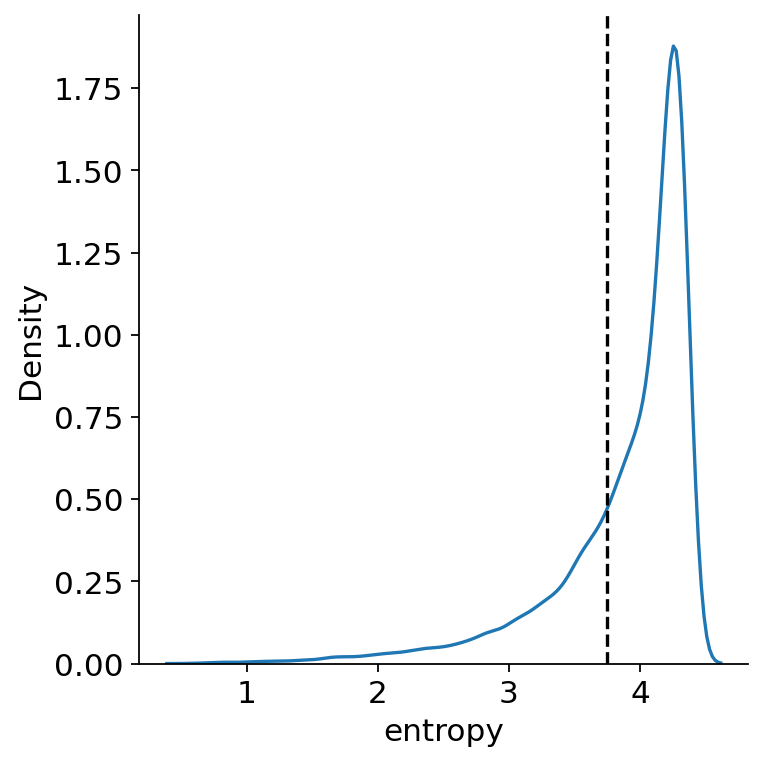

In [13]:
# Plot distribution of entropy scores
ax = sns.displot(tissueEntropy, x="entropy", kind="kde")
plt.axvline(3.75, linestyle="dashed", c="black")
plt.savefig("../../analysis/Paper figs/S3 (Aire KO)/Tabula_Muris_tissue_entropy.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [14]:
# Select TRAs
TRAs = list(tissueEntropy[tissueEntropy.entropy < 3.75].index)
nonTRAs = list(tissueEntropy[tissueEntropy.entropy >= 3.75].index)
tissueEntropy.to_csv("../../analysis/Tabula_muris_TRA_entropy.csv")
pd.DataFrame(TRAs).to_csv("../../analysis/TRA_list.csv")
pd.DataFrame(nonTRAs).to_csv("../../analysis/nonTRA_list.csv")

# Total gene expression

## equalize genes in PBMC, thymus datasets

In [14]:
adataShared = adata[:, adata.var_names[adata.var_names.isin(pbmc.var_names)]]
pbmc = pbmc[:, pbmc.var_names[pbmc.var_names.isin(adataShared.var_names)]]
pbmc.obs["genotype"] = "WT"
pbmc.obs.genotype = pbmc.obs.genotype.astype("category")

/tmp/ipykernel_826204/2010857254.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pbmc.obs["genotype"] = "WT"


## normalized expression

### Subset of cell types

/tmp/ipykernel_826204/1843189659.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)


Late Aire:	Fezf2_KO->WT	p = 39.0712318827198	d = -0.511
Late Aire:	Aire_KO->WT	p = inf	d = -1.543

Ccl21a+:	Fezf2_KO->WT	p = 13.953453901584378	d = -0.223
Ccl21a+:	Aire_KO->WT	p = 45.10902892090091	d = -1.133

Aire+:	Fezf2_KO->WT	p = 84.68963054330385	d = -0.677
Aire+:	Aire_KO->WT	p = inf	d = -2.72

TAC-TECs:	Fezf2_KO->WT	p = 2.082572129912303	d = -0.177
TAC-TECs:	Aire_KO->WT	p = 124.68645273475646	d = -1.524

PA1 (Gp2):	Fezf2_KO->WT	p = 0.7898790167509686	d = -0.199
PA1 (Gp2):	Aire_KO->WT	p = 1.8177793390836898	d = -0.371



/tmp/ipykernel_826204/1843189659.py:27: RuntimeWarning: divide by zero encountered in log10
  print(f"{cell_type}:\t{genotype}->{genotype_list[0]}\tp = {-np.log10(p)}\td = {round(d, 3)}")


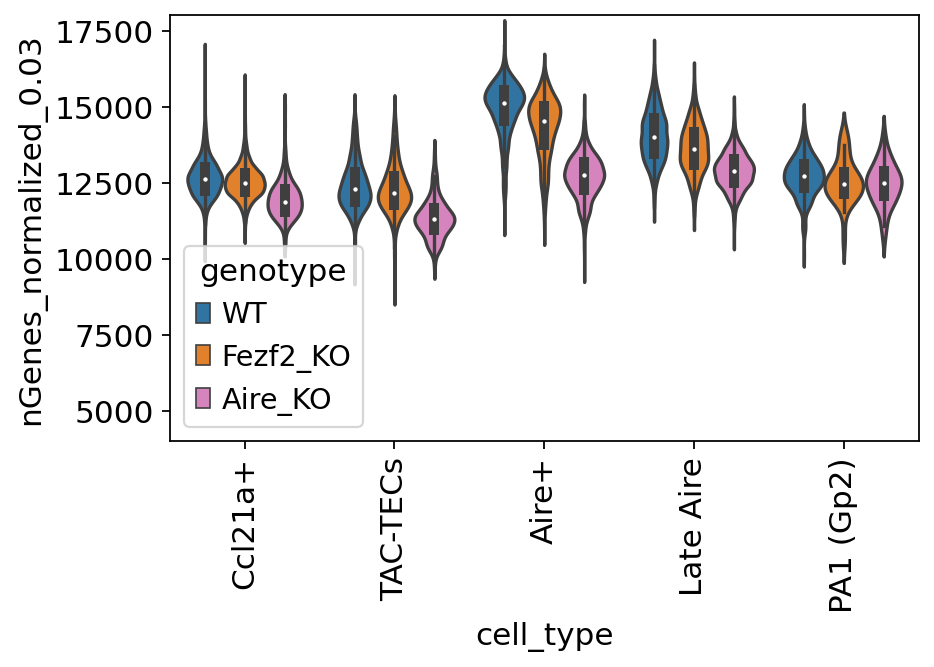

In [15]:
plot_total_genes_normalized_expression(
    adataShared,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)"],
    threshold=0.03,
    palette=["tab:blue", "tab:orange", "tab:pink"],
    vlim=[4000, 18000],
    save_path="../../analysis/Paper figs/2 (Aire KO)/2J_num_genes_expressed.pdf"
)

### PBMCs

/tmp/ipykernel_826204/1843189659.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_copy.obs[f"nGenes_normalized_{threshold}"] = (normalized_expression > threshold).sum(axis=1)


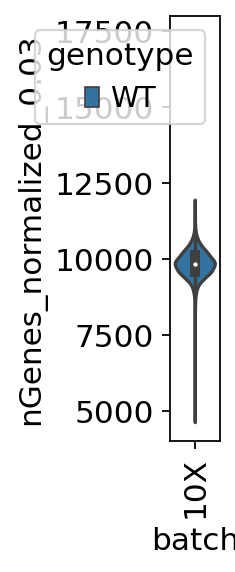

In [16]:
plot_total_genes_normalized_expression(
    pbmc,
    genotype_list=["WT"],
    cell_type_list=pbmc.obs.batch.unique(),
    cell_type_key="batch",
    threshold=0.03,
    palette=["tab:blue"],
    vlim=[4000, 18000],
    save_path="../../analysis/Paper figs/2 (Aire KO)/2J_num_genes_expressed_PBMCs.pdf"
)

# Aire regulated non-TRAs

In [17]:
aireDE = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters.csv",index_col=0)
aireDE = aireDE [aireDE.index.isin(tissueEntropy.index)]
aireDE["entropy"] = tissueEntropy

aireDE_filtered = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_filtered.csv",index_col=0)
aireDE_filtered = aireDE_filtered[aireDE_filtered.index.isin(tissueEntropy.index)]
aireDE_filtered["entropy"] = tissueEntropy

In [18]:
len(aireDE_filtered[aireDE_filtered.lfc_mean < 0])

189

In [19]:
len(aireDE_filtered[aireDE_filtered.lfc_mean > 0])

1060

## Top Aire induced Non-TRAs

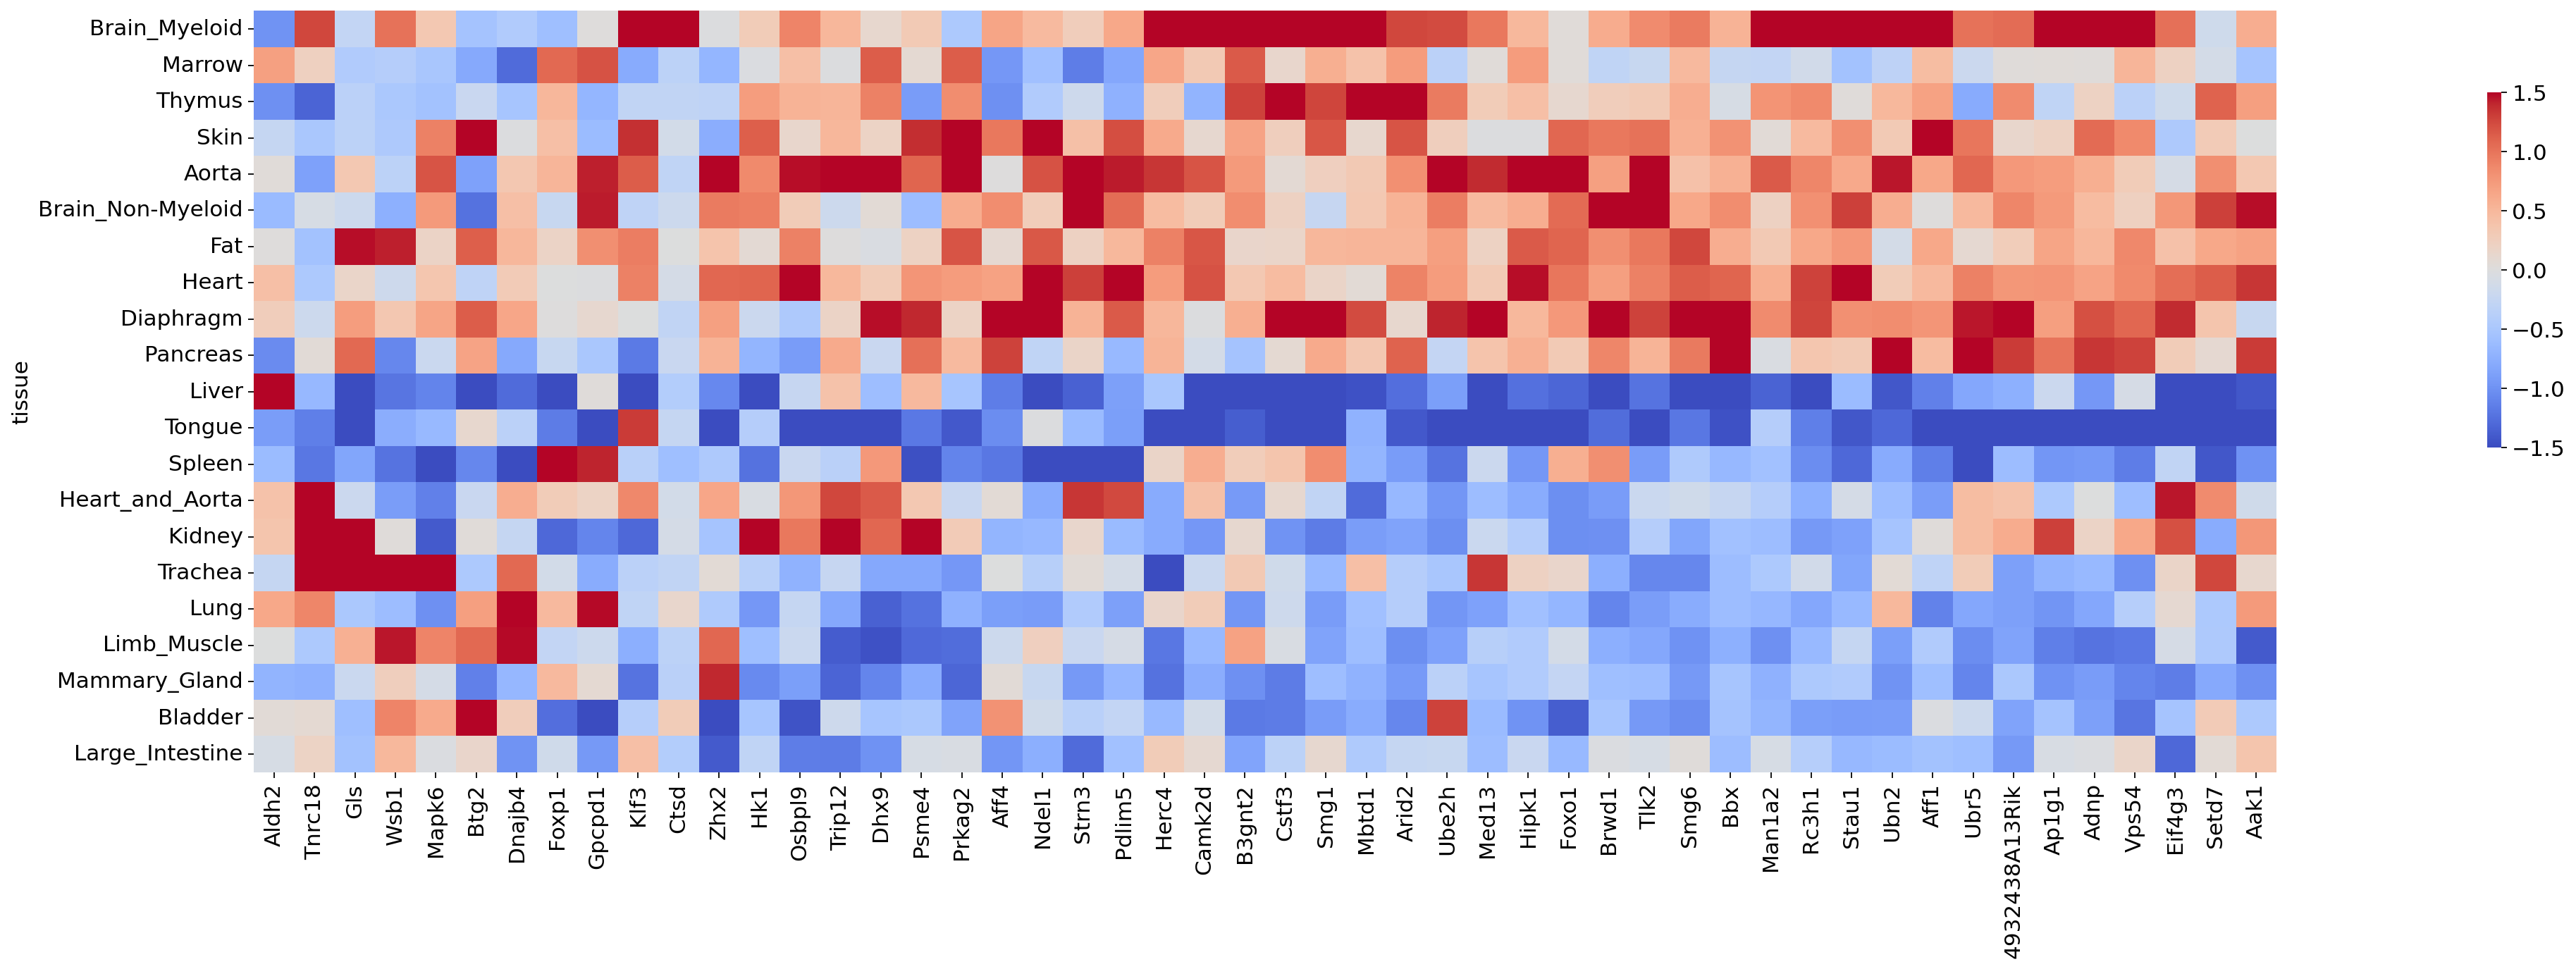

In [20]:
genes = aireDE_filtered[aireDE_filtered.lfc_mean > 0].sort_values(by="entropy", ascending=False).head(50).index
heatmap_gene_expression(
    adata=tabulaMurisData,
    gene_list=genes,
    obs_key="tissue",
    z_score=1,
    vmin=-1.5,
    vmax=1.5,
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3C_Aire_reg_nonTRA_tissue_expression.pdf"
)

## LFC vs entropy for all Aire-reg genes

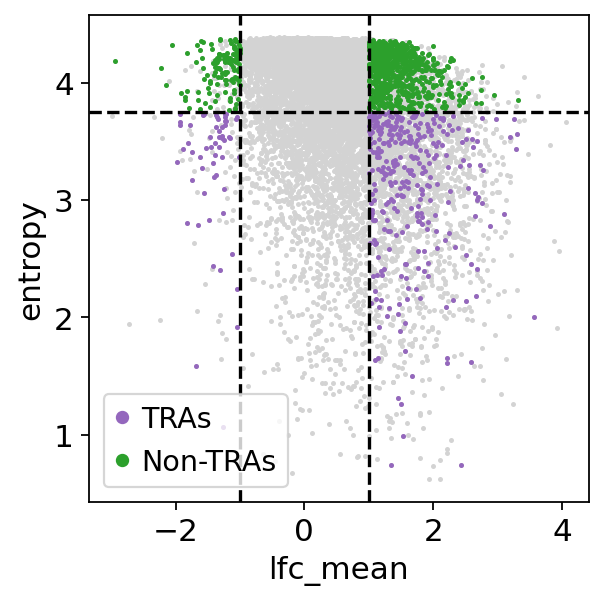

In [21]:
sns.scatterplot(
    x=aireDE.lfc_mean,
    y=aireDE.entropy,
    c="lightgrey",
    linewidth=0,
    s=5
)
sns.scatterplot(
    x=aireDE_filtered[aireDE_filtered.entropy >= 3.75].lfc_mean,
    y=aireDE_filtered[aireDE_filtered.entropy >= 3.75].entropy,
    c="tab:green",
    linewidth=0,
    s=5
)
sns.scatterplot(
    x=aireDE_filtered[aireDE_filtered.entropy < 3.75].lfc_mean,
    y=aireDE_filtered[aireDE_filtered.entropy < 3.75].entropy,
    c="tab:purple",
    linewidth=0,
    s=5
)
plt.axhline(y=3.75, color="black", linestyle="dashed")
plt.axvline(x=-1, color="black", linestyle="dashed")
plt.axvline(x=1, color="black", linestyle="dashed")
TRAs = mlines.Line2D(
    [], [],
    color='tab:purple',
    marker='o',
    linestyle='None',
    markersize=5,
    label='TRAs'
)
nonTRAs = mlines.Line2D(
    [], [],
    color='tab:green',
    marker='o',
    linestyle='None',
    markersize=5,
    label='Non-TRAs'
)
label_genes = []
for gene in label_genes:
    plt.text(
        aireDE[aireDE.index == gene].lfc_mean,
        aireDE[aireDE.index == gene].entropy,
        s=gene,
        color="tab:blue",
        fontdict={"fontsize":12},
    )
plt.legend(handles=[TRAs, nonTRAs])
plt.savefig(
    "../../analysis/Paper figs/2 (Aire KO)/2H_entropy_vs_lfc_mean_Aire_DE.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [22]:
print(f"Number of induced TRAs > 4.25: {len(aireDE_filtered[(aireDE_filtered.entropy >= 4.25) & (aireDE_filtered.lfc_mean > 0)])}")
print(f"Induced genes > 4.25 fraction of induced genes: {len(aireDE_filtered[(aireDE_filtered.entropy >= 4.25) & (aireDE_filtered.lfc_mean > 0)])/len(aireDE_filtered[aireDE_filtered.lfc_mean > 0])}")
print(f"Induced genes > 4.25 fraction of all DE: {len(aireDE_filtered[(aireDE_filtered.entropy >= 4.25) & (aireDE_filtered.lfc_mean > 0)])/len(aireDE_filtered)}")
print()
print((f"Induced non-TRAs: "
      f"Number - {len(aireDE_filtered[(aireDE_filtered.entropy >= 3.75) & (aireDE_filtered.lfc_mean > 0)])}    "
      f"Fraction of induced - {len(aireDE_filtered[(aireDE_filtered.entropy >= 3.75) & (aireDE_filtered.lfc_mean > 0)])/len(aireDE_filtered[aireDE_filtered.lfc_mean > 0])}    "
      f"Fraction of all DE - {len(aireDE_filtered[(aireDE_filtered.entropy >= 3.75) & (aireDE_filtered.lfc_mean > 0)])/len(aireDE_filtered)}")
)

print((f"Induced TRAs: "
      f"Number - {len(aireDE_filtered[(aireDE_filtered.entropy < 3.75) & (aireDE_filtered.lfc_mean > 0)])}    "
      f"Fraction of induced - {len(aireDE_filtered[(aireDE_filtered.entropy < 3.75) & (aireDE_filtered.lfc_mean > 0)])/len(aireDE_filtered[aireDE_filtered.lfc_mean > 0])}    "
      f"Fraction of all DE - {len(aireDE_filtered[(aireDE_filtered.entropy < 3.75) & (aireDE_filtered.lfc_mean > 0)])/len(aireDE_filtered)}")
)
print()
print((f"Repressed non-TRAs: "
      f"Number - {len(aireDE_filtered[(aireDE_filtered.entropy >= 3.75) & (aireDE_filtered.lfc_mean < 0)])}    "
      f"Fraction of repressed - {len(aireDE_filtered[(aireDE_filtered.entropy >= 3.75) & (aireDE_filtered.lfc_mean < 0)])/len(aireDE_filtered[aireDE_filtered.lfc_mean < 0])}    "
      f"Fraction of all DE - {len(aireDE_filtered[(aireDE_filtered.entropy >= 3.75) & (aireDE_filtered.lfc_mean < 0)])/len(aireDE_filtered)}")
)
print((f"Repressed TRAs: "
      f"Number - {len(aireDE_filtered[(aireDE_filtered.entropy < 3.75) & (aireDE_filtered.lfc_mean < 0)])}    "
      f"Fraction of repressed - {len(aireDE_filtered[(aireDE_filtered.entropy < 3.75) & (aireDE_filtered.lfc_mean < 0)])/len(aireDE_filtered[aireDE_filtered.lfc_mean < 0])}    "
      f"Fraction of all DE - {len(aireDE_filtered[(aireDE_filtered.entropy < 3.75) & (aireDE_filtered.lfc_mean < 0)])/len(aireDE_filtered)}")
)

Number of induced TRAs > 4.25: 190
Induced genes > 4.25 fraction of induced genes: 0.1792452830188679
Induced genes > 4.25 fraction of all DE: 0.1521216973578863

Induced non-TRAs: Number - 742    Fraction of induced - 0.7    Fraction of all DE - 0.5940752602081665
Induced TRAs: Number - 318    Fraction of induced - 0.3    Fraction of all DE - 0.2546036829463571

Repressed non-TRAs: Number - 132    Fraction of repressed - 0.6984126984126984    Fraction of all DE - 0.10568454763811048
Repressed TRAs: Number - 57    Fraction of repressed - 0.30158730158730157    Fraction of all DE - 0.045636509207365894
